In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
# %matplotlib notebook

import random
import gudhi as gd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.neighbors import KernelDensity
import numpy as np
from numpy.linalg import norm
from mma import *
from multipers import *
from tqdm import tqdm
from benchmark_functions import *

We first generate the data via noise over an anulus

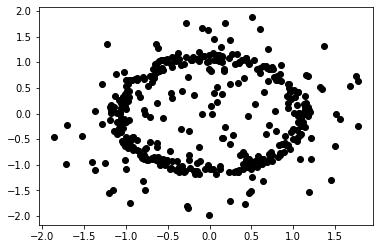

In [2]:
n_pts = 300
seed=42
n_outliers = n_pts * 0.2
X = np.array(noisy_annulus(1,1.2,n_pts, seed=seed) + noisy_annulus(0,1,n_outliers,seed=seed+1) + noisy_annulus(1.2,2,n_outliers, seed=seed+2))
plt.scatter(X[:,0], X[:,1], c='black')
plt.show()

Then we compute an $\alpha$ complex filtration. As you can see, the usual $\alpha$ complex filtration doesn't detect any significant feature; we will add a density estimation to filter features by density to check if we can find the noisy circle.

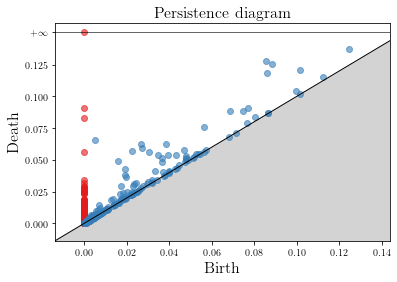

In [3]:
alpha_complex = gd.AlphaComplex(points=X)
simplex_tree = alpha_complex.create_simplex_tree()
simplex_tree.persistence()
dgm_alpha = simplex_tree.persistence_intervals_in_dimension(1)
gd.plot_persistence_diagram(simplex_tree.persistence())
plt.show()

We then compute an approximation of the density via a (gaussian) kernel density estimation (one can choose a simpler filtration to kill the outliers).

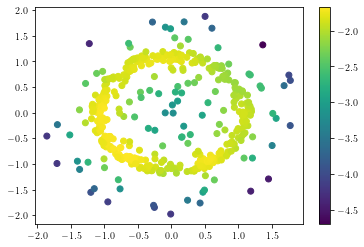

In [4]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(kernel='gaussian', bandwidth=.3).fit(X)
density = kde.score_samples(X)
plt.figure()
plt.scatter(X[:,0],X[:,1], c=density)
plt.colorbar()
plt.show()
# plt.savefig("circle+density.svg")

We then generate the boundary matrix and associated bifiltration with `ls_boundary_density`. We have to use this function because `filtration_density` is ordered with respect to the points (ie. is already ordered) and the simplices are ordered according to the order given by `Gudhi` (ie. is not ordered and has to be permuted, hence `to_permute = [0]`); this functions ensures that the filtrations and the boundary matrix have the same basis.

If available, this function will call `shapely` instead of `matplotlib` to plot the summands; it is useful when using the `alpha` parameter, as in the other case, it doesn't provide a correct output. 

Filtration dimension : 2
Number of simplices : 2487
Precision : 0.001
Number of lines : 3000
Creating matrix ... Done !
Initializing barcode... Done ! It took 0.000532 seconds.
Multithreading status : 0
Starting recursive vineyard loop... Done ! It took 0.218939 seconds.
Cleaning output ... Completing output ... Done ! It took 0.000701561 seconds.


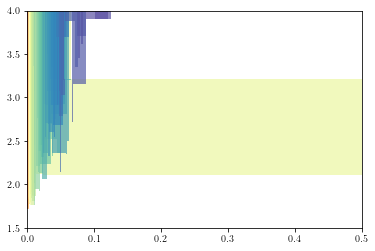

CPU times: user 1.06 s, sys: 14.1 ms, total: 1.07 s
Wall time: 1.08 s


In [5]:
filtration_density = -np.array(density)
filtration_alpha = np.array([simplex_tree.filtration(s) for s,_ in simplex_tree.get_simplices()])
bifiltration = [filtration_alpha, filtration_density]
box = [[0,1.5],[0.5,4]]
precision=0.001
boundary, filters = ls_boundary_density(simplex_tree, bifiltration, to_permute=[0])
%time plot_approx_2d(boundary, filters,precision,box=box, dimension=1, separated=0, verbose=True, keep_order=1, min_interleaving =0, complete = 1, alpha = 0.7)

The vertical filtration corresponds to the density and the $\alpha$-complex filtration is the horizontal one. We can see here that we only have 1 signifiant interval summand; which corresponds to the noisy circle. One can use another density filtration such as k-nearest neighbors to have a smaller computational cost.

One can also compute a persistence image (which is bottleneck stable) of this module : 

Filtration dimension : 2
Number of simplices : 2487
Precision : 0.001
Number of lines : 19257
Creating matrix ... Done !
Initializing barcode... Done ! It took 0.000556 seconds.
Multithreading status : 0
Starting recursive vineyard loop... Done ! It took 0.537664 seconds.
Cleaning output ... Completing output ... Done ! It took 0.000109233 seconds.
Computing image of dimension 1 ...Computing module weight ... Done ! It took 0.000243539 seconds.
Module weight : 1.8549
Computing pixel values ... Done ! It took 0.0574547 seconds.
 Done ! It took 0.0577497 seconds.


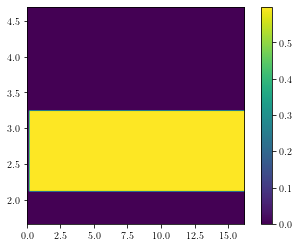

In [6]:
persistence_image_2d(boundary, filters, dimension=1, precision = 0.001,bandwidth=0.001,verbose=True);

## Convergence wrt increasing precision / number of lines

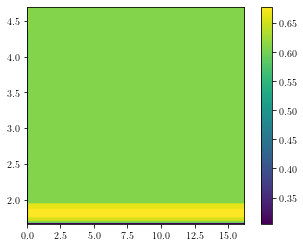

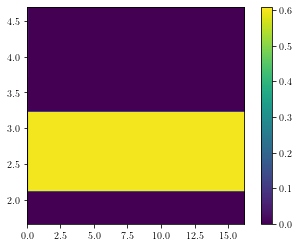

100%|█████████████████████████████████████████| 200/200 [03:33<00:00,  1.07s/it]


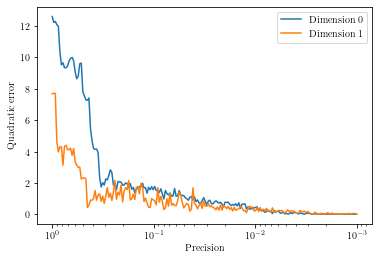

In [7]:
convergence_image(boundary, filters, 0.001, 0.001, box=box, num=200, save="Noisy_circle");